### Libs

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
from pyefd import elliptic_fourier_descriptors
import pyefd
from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

In [2]:
from skimage.segmentation import clear_border
from skimage import color
from scipy import ndimage
from scipy.ndimage.morphology import binary_fill_holes

In [3]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
from tqdm import tqdm_notebook, tqdm, trange
from os import listdir
from random import shuffle
import random
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score, confusion_matrix 

### Functions

In [4]:
def enhanceAndFill(img):
    try:
        gs1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        gs1 = img.copy()
    # LoG for sharpening edges
    blurred1 = cv2.GaussianBlur(gs1, (3, 3), 0)
    lap  = cv2.Laplacian(blurred1, cv2.CV_64F)
    sharpened = (gs1-lap).astype("uint8")

    # otsu thresholding 
    _, otsu1 = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # masking and taking ROI then make background all white
    mask = np.invert(otsu1)
    imageROI = cv2.bitwise_and(sharpened, sharpened, mask=mask)
    imageROI[imageROI == 0] = 255

    # thresholding
    otsu2 = cv2.adaptiveThreshold(imageROI, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 99, 20)

    # fill holes
    otsu2[otsu2 == 0] = 1
    otsu2[otsu2 == 255] = 0
    otsu2 = otsu2.astype(np.int8)
    filled1 = binary_fill_holes(otsu2)
    filled1 = filled1.astype(np.uint8)
    filled1[filled1 == 0] = 255
    filled1[filled1 == 1] = 0
    
    return filled1

In [5]:
def enhanceAndFill2(img):
    try:
        gs1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        gs1 = img.copy()
    # LoG for sharpening edges
    blurred1 = cv2.GaussianBlur(gs1, (3, 3), 0)
    lap  = cv2.Laplacian(blurred1, cv2.CV_64F)
    sharpened = (gs1-lap).astype("uint8")

    # otsu thresholding 
    otsu1 = cv2.adaptiveThreshold(sharpened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 379, 20)
    

    # masking and taking ROI then make background all white
    mask = np.invert(otsu1)
    imageROI = cv2.bitwise_and(gs1, gs1, mask=mask)
    imageROI[imageROI == 0] = 255

    # thresholding
    _, otsu2 = cv2.threshold(imageROI, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # fill holes
    otsu2[otsu2 == 0] = 1
    otsu2[otsu2 == 255] = 0
    otsu2 = otsu2.astype(np.int8)
    filled1 = binary_fill_holes(otsu2)
    filled1 = filled1.astype(np.uint8)
    filled1[filled1 == 0] = 255
    filled1[filled1 == 1] = 0
    
    return filled1

In [6]:
def watershedSegmentation(img, img_source):
    filled2 = img.copy()
    filled2 = np.invert(filled2)

    # noise removal
    kernel = np.ones((3,3), np.uint8)
    WSopening = cv2.morphologyEx(filled2, cv2.MORPH_OPEN, kernel, iterations=2)

    # sure bg area
    sure_bg = cv2.dilate(WSopening, kernel, iterations=2)

    # sure fg area
    dist_transform = cv2.distanceTransform(WSopening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.3*dist_transform.max(), 255, 0)

    # unknown
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # mark labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # add one to all labels
    markers = markers+1

    # mark the unknown with 0
    markers[unknown == 255] = 0

    markers = cv2.watershed(img_source, markers)
    # img1[markers == -1] = [255, 0, 0]

    # finding contours from markers
    markers1 = markers.astype(np.uint8)
    ret, markers2 = cv2.threshold(markers1, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return markers2, markers

In [7]:
def watershedSegmentation2(img, img_source):
    filled2 = img.copy()
    filled2 = np.invert(filled2)

    # noise removal
    kernel = np.ones((3,3), np.uint8)
    WSopening = cv2.morphologyEx(filled2, cv2.MORPH_OPEN, kernel, iterations=1)

    # sure bg area
    sure_bg = cv2.dilate(filled2, kernel, iterations=1)

    # sure fg area
    dist_transform = cv2.distanceTransform(filled2, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.475*dist_transform.max(), 255, 0)

    # unknown
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # mark labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # add one to all labels
    markers = markers+1

    # mark the unknown with 0
    markers[unknown == 255] = 0

    markers = cv2.watershed(img_source, markers)
    # img1[markers == -1] = [255, 0, 0]

    # finding contours from markers
    markers1 = markers.astype(np.uint8)
    ret, markers2 = cv2.threshold(markers1, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return markers2, markers

In [8]:
def rotate2(img,degree=0):
    cnts, h = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(cnts, key=cv2.contourArea)   # first largest is the box

#     FILTERING ELLIPS CONTOUR ONLY WITH ECC >= 0.9
    selected_cnt = []
    for c in cnt:
        H, W = markers.shape[:2]
        img_area = float(H) * float(W)
        cnt_area = cv2.contourArea(c)
        if cnt_area / img_area < 0.01 or cnt_area / img_area > 0.9: # tadinya lebih dari 0.4
            continue
        selected_cnt.append(c)

    c = max(selected_cnt, key=cv2.contourArea)
    
    # rotate functins
    mask = np.zeros(img.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    (x, y, w, h) = cv2.boundingRect(c)
    imgROI = img[y:y+h, x:x+w]
    maskROI = mask[y:y+h, x:x+w]
    imgROI = cv2.bitwise_and(imgROI, imgROI, mask=maskROI)

    rotated_img = imutils.rotate_bound(imgROI, degree)
    rot_mask = imutils.rotate_bound(maskROI, degree)
    rotated_img[rot_mask == 0] = 255
    return rotated_img

In [9]:
def rotate(img,degree=0):
    cnts, h = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(cnts, key=cv2.contourArea)   # first largest is the box

    # FILTERING ELLIPS CONTOUR ONLY WITH ECC >= 0.9
    ellips_cnt = []
    for c in cnt:
        try:
            ellipse = cv2.fitEllipse(c)
            (center, axes, orientation) = ellipse
            major_length = max(axes)
            minor_length = min(axes)
            ecc = (np.sqrt(1-(minor_length/major_length)**2))
            if ecc >= 0.9:
                ellips_cnt.append(c)
        except:
            pass

    c = max(ellips_cnt, key=cv2.contourArea)

    # rotate functins
    mask = np.zeros(img.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    (x, y, w, h) = cv2.boundingRect(c)
    imgROI = img[y:y+h, x:x+w]
    maskROI = mask[y:y+h, x:x+w]
    imgROI = cv2.bitwise_and(imgROI, imgROI, mask=maskROI)

    rotated_img = imutils.rotate_bound(imgROI, degree)
    rot_mask = imutils.rotate_bound(maskROI, degree)
    rotated_img[rot_mask == 0] = 255
    return rotated_img

In [10]:
def resizeAndPad(img, size, padColor=255):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)
    
    h_, w_ = scaled_img.shape
    back = np.zeros((scaled_img.shape[0]+20, scaled_img.shape[1]+20))           # adding more space
    back.fill(255)
    hh, ww = back.shape

    yoff = round((hh-h_)/2)
    xoff = round((ww-w_)/2)

    result = back.copy()
    result[yoff:yoff+h_, xoff:xoff+w_] = scaled_img
    result = result.astype('uint8')
    
    return result

In [11]:
def get_contour(img):
    gray2 = cv2.GaussianBlur(img, (3, 3), 0)
    _, final_th = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cnts, h = cv2.findContours(final_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    c2 = sorted(cnts, key=cv2.contourArea)
    return c2[-2]

In [12]:
def preprocess_img(img, img_size=250, degree=0):
    global resized
    enhanced = enhanceAndFill(img)
    markers = watershedSegmentation(enhanced)
    rotated = rotate(markers, degree)
    resized = resizeAndPad(rotated, (img_size,img_size))
    c = get_contour(resized)
    return c

In [13]:
def extract_efd(img):
    cont = img.reshape(-1,2)
    coeffs = elliptic_fourier_descriptors(cont, order=10, normalize='True')
    return coeffs.flatten()[3:]

In [14]:
def extract_fft(cnt):
    M = cv2.moments(cnt)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    rr = []
    for c in cnt:
        xx = c[0][0]
        yy = c[0][1]
        r = np.sqrt((xx-cX)**2 + (yy-cY)**2)
        rr.append(r)
    coef = np.fft.fft(rr)/(len(rr))
    for i,c in enumerate(coef):
        coef[i] = np.abs(coef[i]/coef[0])
    coef = np.real(coef).flatten()[:50]
    return coef

In [15]:
def scale_img(img, scale):
    scale_percent = scale # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_CUBIC)
    return resized

### CONCAVE POINT DETECTION

In [67]:
def merge_contour(c1, c2):
    return np.concatenate((np.array(c1).reshape(-1,1,2), np.array(c2).reshape(-1,1,2)))

In [68]:
def get_centroid(c):
    M = cv2.moments(np.array(c))
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return cx, cy

In [69]:
def midpoint(p1, p2):
    return ((p1[0]+p2[0])/2, (p1[1]+p2[1])/2)

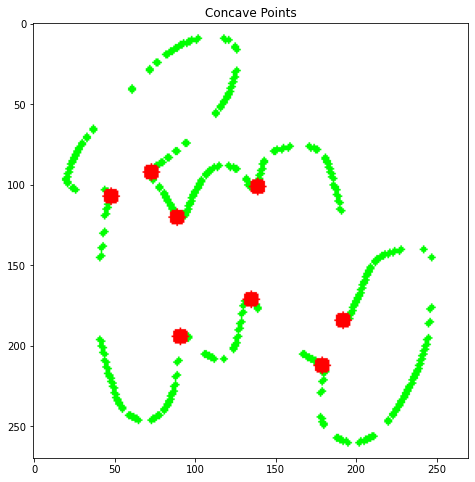

In [298]:
# for i in range(len(props)):
img_test = cv2.imread('dummy.jpg', 0)

scaled_test = scale_img(img_test, 400)
props_img = cv2.cvtColor(img_test, cv2.COLOR_GRAY2BGR)
props_img = scale_img(props_img, 400)

enhanced = enhanceAndFill(scaled_test)
markers, _ = watershedSegmentation(enhanced, props_img)
rotated = rotate2(markers, 0)
resized = resizeAndPad(rotated, (img_size,img_size))

blurred = cv2.medianBlur(resized, 11)
_, final = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

cnts, h = cv2.findContours(final, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
c = sorted(cnts, key=cv2.contourArea)

peri = cv2.arcLength(c[-2], True)
approx = cv2.approxPolyDP(c[-2], 0.01*peri, True)

# for every point in approx above, check if it's inside c[-2] contour or no
concave_points = list()
for n, poi in enumerate(approx):
    if n != len(approx)-1:
        midpt = midpoint(approx[n-1][0], approx[n+1][0])
        dist = cv2.pointPolygonTest(c[-2], midpt, False)
        if dist < 0:    
            concave_points.append(approx[n])
    else:
        midpt = midpoint(approx[n-1][0], approx[0][0])
        dist = cv2.pointPolygonTest(c[-2], midpt, False)
        if dist < 0:
            concave_points.append(approx[n])

blank_img = np.ones((resized.shape[0], resized.shape[1], 3))
cv2.drawContours(blank_img, c[-2], -1, (0, 1, 0), 3)
cv2.drawContours(blank_img, concave_points, -1, (1, 0, 0), 10)
plt.figure(figsize=(8,8))
plt.title('Concave Points')
plt.imshow(blank_img)
plt.show()


In [299]:
CPidx = list()

for i, p in enumerate(c[-2]):
    if p[0].tolist() in np.array(concave_points).reshape(-1, 2).tolist():
        CPidx.append(i)
CPidx

[39, 57, 96, 140, 258, 276, 307, 380]

-16.796978398812023
5.701583063372379
-4.70330318082554
-74.93268748044729
-37.508817597868344
-31.77040395157874
-40.78343304856671
-4.559765539386729


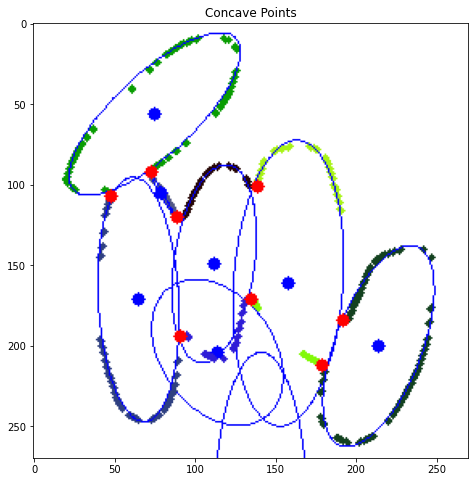

In [300]:
def split_list(alist, idxlist):
    return [alist[i:j] for i, j in zip([0]+idxlist, idxlist+[None])]

contour_segment = split_list(c[-2].tolist(), CPidx)
contour_segment[0] = merge_contour(contour_segment[0], contour_segment[-1]).tolist()
contour_segment.pop(-1)

blank_img = np.ones((resized.shape[0], resized.shape[1], 3))

for cs in contour_segment:
    cv2.drawContours(blank_img, np.array(cs), -1, (np.random.randint(0,255)/255,
                                                   np.random.randint(0,255)/255,
                                                   np.random.randint(0,255)/255), 3)
    
    ((centx,centy), axes, angle) = cv2.fitEllipse(np.array(cs))
    cv2.ellipse(blank_img, (int(centx),int(centy)), (int(axes[0]/2),int(axes[1]/2)), angle, 0, 360, (0,0,1), 1)
    cv2.circle(blank_img, (int(centx),int(centy)), 4, (0,0,1), -1)   
    
    # major and minor (a & b)
    major_length = max(axes)
    minor_length = min(axes)
    
    # get angle
    if angle > 90:
        angle = 90 + angle
    elif angle <= 90:
        angle = 90 - angle
    
    cs_ = np.array(cs).reshape(-1,2)
    sigma_ADDi = 0
    for p in cs_:
        xi = p[0]
        yi = p[1]
        
        xi_ = (np.cos(angle)*(xi-int(centx))) - (np.sin(angle)*(yi-int(centy)))
        yi_ = (np.sin(angle)*(xi-int(centx))) + (np.cos(angle)*(yi-int(centy)))
        
        Di = np.sqrt((xi_**2) / (major_length**2) + (yi_**2) / (minor_length**2))
        ADDi = (np.sqrt((xi_**2)+(yi_**2))) * (1 - (1/np.abs(Di)))
        sigma_ADDi += ADDi
        
    print(sigma_ADDi/len(cs_))
        
    
cv2.drawContours(blank_img, concave_points, -1, (1, 0, 0), 8)
plt.figure(figsize=(8,8))
plt.title('Concave Points')
plt.imshow(blank_img)
plt.show()

In [278]:
def calculate_ellipticity(cnt1, cnt2=None):
    if cnt2 is not None:
        pass # merge contour
    else:
        cnt2process = np.array(cnt1).reshape(-1,2)

    ((centx,centy), axes, angle) = cv2.fitEllipse(cnt2process)
    cv2.ellipse(blank_img, (int(centx),int(centy)), (int(axes[0]/2),int(axes[1]/2)), angle, 0, 360, (0,0,1), 1)
    cv2.circle(blank_img, (int(centx),int(centy)), 4, (0,0,1), -1)   

    # major and minor (a & b)
    major_length = max(axes)
    minor_length = min(axes)

    # get angle
    if angle > 90:
        angle = 90 + angle
    elif angle <= 90:
        angle = 90 - angle

    
    sigma_ADDi = 0
    for p in cnt2process:
        xi = p[0]
        yi = p[1]
        
        # transform
        xi_ = (np.cos(angle)*(xi-int(centx))) - (np.sin(angle)*(yi-int(centy)))
        yi_ = (np.sin(angle)*(xi-int(centx))) + (np.cos(angle)*(yi-int(centy)))

        Di = np.sqrt((xi_**2) / (major_length**2) + (yi_**2) / (minor_length**2))
        ADDi = (np.sqrt((xi_**2)+(yi_**2))) * (1 - (1/np.abs(Di)))
        sigma_ADDi += ADDi

    return np.abs(sigma_ADDi/len(cnt2process))/100

-10.007757906790303


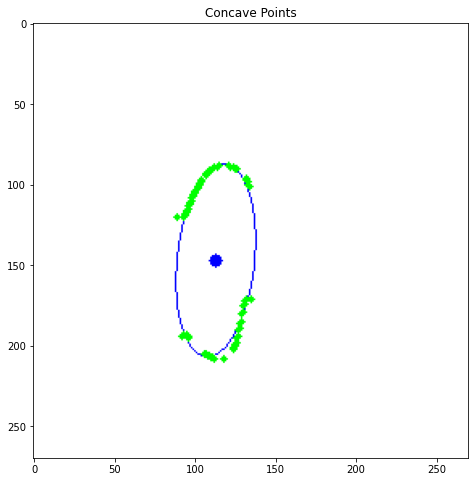

In [35]:
# ELLIPTICITY

blank_img = np.ones((resized.shape[0], resized.shape[1], 3))
merged_cnt = merge_contour(contour_segment[2], contour_segment[6])
# merged_cnt = merge_contour(merged_cnt, contour_segment[2])
# merged_cnt = np.array(contour_segment[2]).reshape(-1,1,2)

((centx,centy), axes, angle) = cv2.fitEllipse(merged_cnt)
cv2.ellipse(blank_img, (int(centx),int(centy)), (int(axes[0]/2),int(axes[1]/2)), angle, 0, 360, (0,0,1), 1)
cv2.circle(blank_img, (int(centx),int(centy)), 4, (0,0,1), -1)   

# major and minor (a & b)
major_length = max(axes)
minor_length = min(axes)

# get angle
if angle > 90:
    angle = 90 + angle
elif angle <= 90:
    angle = 90 - angle

cs_ = np.array(merged_cnt).reshape(-1,2)
sigma_ADDi = 0
for p in cs_:
    xi = p[0]
    yi = p[1]
    
    # transform
    xi_ = (np.cos(angle)*(xi-int(centx))) - (np.sin(angle)*(yi-int(centy)))
    yi_ = (np.sin(angle)*(xi-int(centx))) + (np.cos(angle)*(yi-int(centy)))

    Di = np.sqrt(((xi_**2) / (major_length**2)) + ((yi_**2) / (minor_length**2)))
    ADDi = (np.sqrt((xi_**2)+(yi_**2))) * (1 - (1/np.abs(Di)))
    sigma_ADDi += ADDi

print((sigma_ADDi/len(cs_)))
cv2.drawContours(blank_img, merged_cnt, -1, (0, 1, 0), 3)
plt.figure(figsize=(8,8))
plt.title('Concave Points')
plt.imshow(blank_img)
plt.show()

In [87]:
def calculate_concavity(cnt1, cnt2=None):
    if cnt2 is not None:
        cnt_ = merge_contour(cnt1, cnt2)
        cnt_ = np.array(cnt_).reshape(-1,1,2)
    else:
        cnt_ = np.array(cnt1).reshape(-1,1,2)
    
    hull = cv2.convexHull(cnt_)

    peri = cv2.arcLength(cnt_, True)
    approx_ = cv2.approxPolyDP(cnt_, 0.015*peri, True)

    # cek if theres any concave point?
    concave_points_ = list()
    for n, poi in enumerate(approx_):
        if n != len(approx_)-1:
            midpt = midpoint(approx_[n-1][0], approx_[n+1][0])
            dist = cv2.pointPolygonTest(cnt_, midpt, False)
            if dist < 0:    
                concave_points_.append(approx_[n])
        else:
            midpt = midpoint(approx_[n-1][0], approx_[0][0])
            dist = cv2.pointPolygonTest(cnt_, midpt, False)
            if dist < 0:
                concave_points_.append(approx_[n])

    if len(concave_points_) == 0:
        return (1-cv2.contourArea(cnt_)/cv2.contourArea(hull))
    else:
        return 1

0.2732570326583659


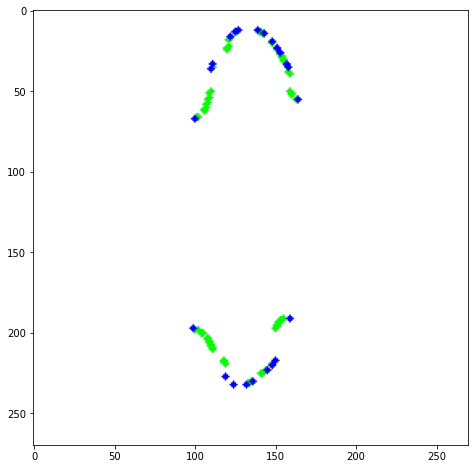

In [80]:
# CONCAVITY TEST
test_cnt = merge_contour(contour_segment[0], contour_segment[2])
# test_cnt = merge_contour(test_cnt, contour_segment[3])
# test_cnt = np.array(contour_segment[3]).reshape(-1,1,2)
hull = cv2.convexHull(test_cnt)

peri = cv2.arcLength(test_cnt, True)
approx_ = cv2.approxPolyDP(test_cnt, 0.02*peri, True)

# cek if theres any concave point?
concave_points_ = list()
for n, poi in enumerate(approx_):
    if n != len(approx_)-1:
        midpt = midpoint(approx_[n-1][0], approx_[n+1][0])
        dist = cv2.pointPolygonTest(test_cnt, midpt, False)
        if dist < 0:    
            concave_points_.append(approx_[n])
    else:
        midpt = midpoint(approx_[n-1][0], approx_[0][0])
        dist = cv2.pointPolygonTest(test_cnt, midpt, False)
        if dist < 0:
            concave_points_.append(approx_[n])

if len(concave_points_) < 1:
    concavity = 1*(1-cv2.contourArea(test_cnt)/cv2.contourArea(hull))
else:
    concavity = 1
print(concavity)

blank_img = np.ones((resized.shape[0], resized.shape[1], 3))
cv2.drawContours(blank_img, test_cnt, -1, (0, 1, 0), 3)
cv2.drawContours(blank_img, concave_points_, -1, (1, 0, 0), 10)
cv2.drawContours(blank_img, hull, -1, (0, 0, 1), 3)
plt.figure(figsize=(8,8))
plt.imshow(blank_img, cmap='gray')
plt.show()

In [301]:
import itertools
combination_idx = [i for i in range(len(contour_segment))]
level_list = [list(itertools.combinations(combination_idx,r=i+1)) for i in range(len(contour_segment))]

optimal_set = list()

alpha = 0.7
betha = 1-alpha

for n in combination_idx:
    buffer_ = False
    for combination_list in level_list:
        for combination in combination_list:
            if combination[0] == n:
                if len(combination) == 1:
                    # cek apa udah ada dalem optimal list optimal_set[n]
                    try:
                        for i in range(len(optimal_set)):
                            if combination[0] in optimal_set[i][0]:
                                optimal_set.append([combination, optimal_set[i][1]])
                                break
                    except Exception as e:
                        pass

                    cnt2process = np.array(contour_segment[combination[0]]).reshape(-1,1,2)

                    # itung J nya sendiri dulu
                    concavity = calculate_concavity(cnt2process)
                    ellipticity = calculate_ellipticity(cnt2process)

                    J = alpha * concavity + betha * ellipticity
                    
                    # kalo optimal set ke n udah ada isinya, skip
                    if len(optimal_set) < n+1:
                        optimal_set.append([combination, J])


                # iterasi loop level >= 2
                for i in range(len(contour_segment)): 
                    if len(combination) == i+2:
                        
                        # iterasi looping sebanyak panjang optimal set
                        # cek combination (index 0 s/d -2) udah ada dalem optimal_set?
                        if combination[:i+1] == optimal_set[n][0]:
                            
                            cnt2process = np.array(contour_segment[combination[0]]).reshape(-1,1,2)
                            
                            for k in range(len(combination)-1):
                                cnt2process = merge_contour(cnt2process,
                                                            contour_segment[combination[k+1]])

                            cnt2process = np.array(cnt2process).reshape(-1,1,2)

                            # itung J
                            concavity = calculate_concavity(cnt2process)
                            ellipticity = calculate_ellipticity(cnt2process)
                            J = alpha * concavity + betha * ellipticity
                            
                            if J < optimal_set[n][1]:
                                buffer_comb = combination
                                buffer_J = J
                                buffer_ = True

        if buffer_ is True:
            optimal_set[n] = [buffer_comb, buffer_J]
            buffer_ = False

print(f'{optimal_set}')


[[(0,), 0.06418631473438988], [(1, 7), 0.18469034173535204], [(2, 6), 0.049653758708823555], [(3, 5), 0.09189461258589393], [(4,), 0.12623266053791973], [(5,), 0.09189461258589393], [(6,), 0.049653758708823555], [(7,), 0.18469034173535204]]


In [302]:
optimal_set_dict = dict()

for k, S in enumerate(optimal_set):
    optimal_set_dict[S[0]] = S[1]
    for OS in list(optimal_set_dict.keys()):
        if S[0][0] in OS[1:] and S[1] in list(optimal_set_dict.values())[:-1]:
            print(f'{S[0]} in {OS[1:]} and {S[1] in list(optimal_set_dict.values())[:-1]}')
            optimal_set_dict.pop(S[0], None)

new_optimal_set = list(optimal_set_dict.keys())

(5,) in (5,) and True
(6,) in (6,) and True
(7,) in (7,) and True


In [303]:
final_contour_segment = list()

for comb_ in new_optimal_set:
    grouped_cnt = np.array(contour_segment[comb_[0]]).reshape(-1,1,2)
    
    if len(comb_) > 1:
        grouped_cnt = np.array(contour_segment[comb_[0]]).reshape(-1,1,2)
                            
        for k in range(len(comb_)-1):
            grouped_cnt = merge_contour(grouped_cnt,
                                        contour_segment[comb_[k+1]])

    grouped_cnt = np.array(grouped_cnt).reshape(-1,1,2)
    final_contour_segment.append(grouped_cnt)

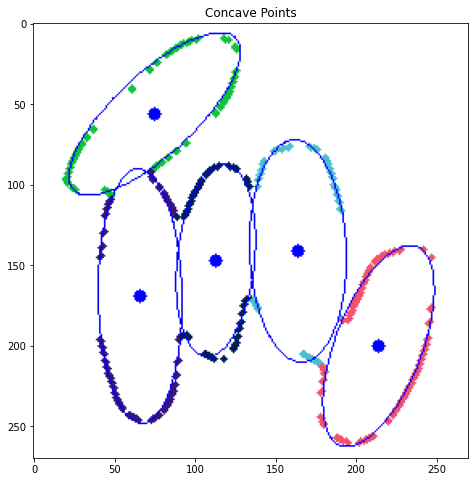

In [304]:
blank_img = np.ones((resized.shape[0], resized.shape[1], 3))

for cs in final_contour_segment:
    cv2.drawContours(blank_img, np.array(cs), -1, (np.random.randint(0,255)/255,
                                                   np.random.randint(0,255)/255,
                                                   np.random.randint(0,255)/255), 3)
    ((centx,centy), axes, angle) = cv2.fitEllipse(cs)
    cv2.ellipse(blank_img, (int(centx),int(centy)), (int(axes[0]/2),int(axes[1]/2)), angle, 0, 360, (0,0,1), 1)
    cv2.circle(blank_img, (int(centx),int(centy)), 4, (0,0,1), -1)

# cv2.drawContours(blank_img, concave_points, -1, (1, 0, 0), 8)
plt.figure(figsize=(8,8))
plt.title('Concave Points')
plt.imshow(blank_img)
plt.show()

### Segmentation HP

In [ ]:
import joblib

pca = joblib.load("pca16-efd-090421.pkl")
scaler = joblib.load("scaler16-efd-090421.pkl")
search = joblib.load("mlp-efd-pca16-070421.pkl")
search_efd = joblib.load("gs_efd.pkl")


In [63]:
otsu1thresh = 199 # gambar gede 479
dist_const = 0.1# gambar gede 0.1
img_size = 250

rect_width = 3 # 5
font_size = 1 # 3
font_width = 1 # 5

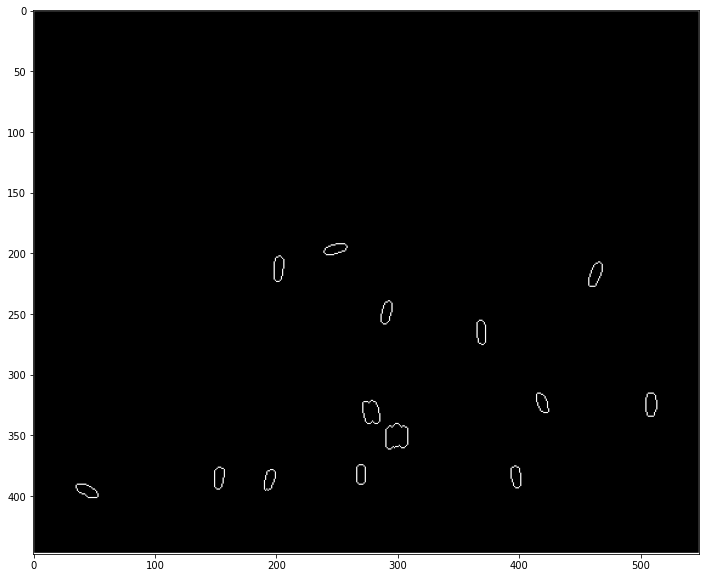

In [64]:
img1 = cv2.imread("IMG_38231.jpeg")
gs1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

otsu1 = cv2.adaptiveThreshold(gs1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, otsu1thresh, 30)

mask = np.invert(otsu1)
imageROI = cv2.bitwise_and(gs1, gs1, mask=mask)
imageROI[imageROI == 0] = 255

_, otsu2 = cv2.threshold(imageROI, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

otsu2[otsu2 == 0] = 1
otsu2[otsu2 == 255] = 0
otsu2 = otsu2.astype(np.int8)
filled1 = binary_fill_holes(otsu2)
filled1 = filled1.astype(np.uint8)
filled1[filled1 == 0] = 255
filled1[filled1 == 1] = 0

filled2 = filled1.copy()
filled2 = np.invert(filled2)

kernel = np.ones((3,3), np.uint8)
WSopening = cv2.morphologyEx(filled2, cv2.MORPH_OPEN, kernel, iterations=2) # gede 10

sure_bg = cv2.dilate(WSopening, kernel, iterations=2)

dist_transform = cv2.distanceTransform(WSopening, cv2.DIST_L2, 3)
ret, sure_fg = cv2.threshold(dist_transform, dist_const*dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# mark labelling
ret, markers = cv2.connectedComponents(sure_fg)

# add one to all labels
markers = markers+1

# mark the unknown with 0
markers[unknown == 255] = 0

markers = cv2.watershed(img1, markers)
# img1[markers == -1] = [255, 0, 0]

# finding contours from markers
markers1 = markers.astype(np.uint8)
ret, markers2 = cv2.threshold(markers1, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize=(20,10))
plt.imshow(markers2, cmap='gray')
plt.show()

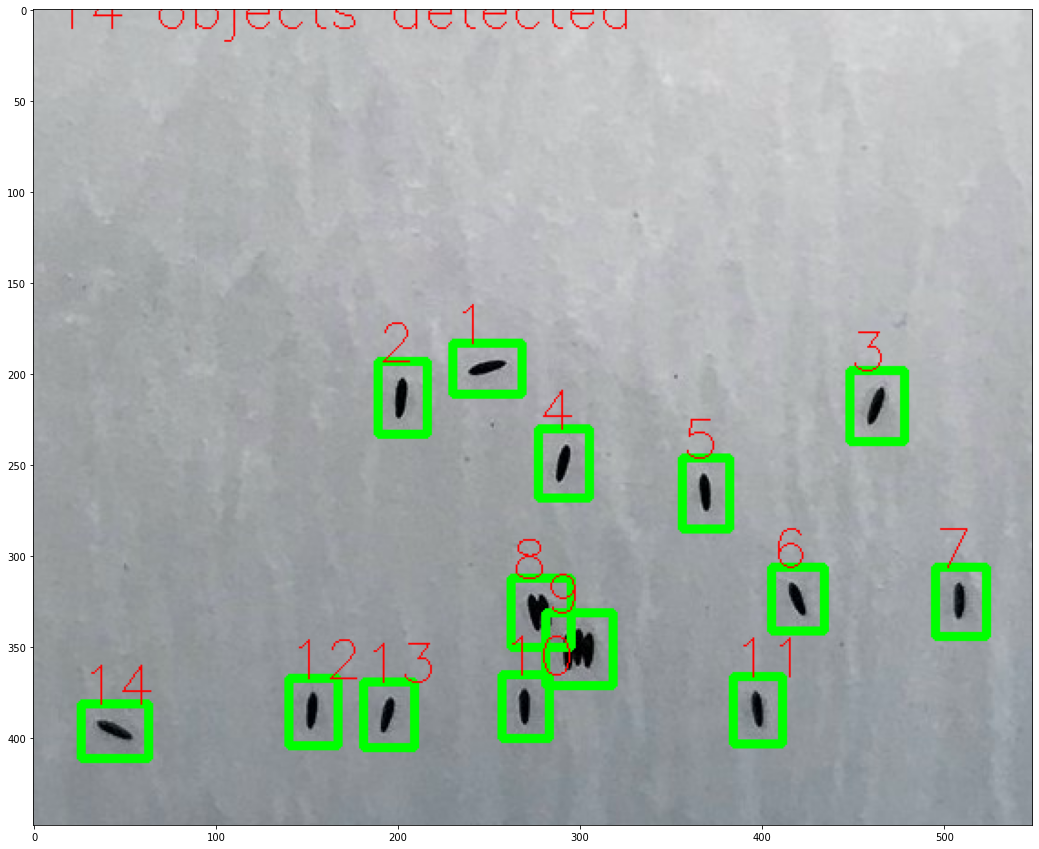

In [65]:
_, segmented = markers2, markers

boxes = list()
props = list()
img_copy = img1.copy()

for label in np.unique(segmented):
    if label == 0:
        continue
        
    mask = np.zeros(_.shape, dtype="uint8")
    mask[segmented == label] = 255
    
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    H, W = img1.shape[:2]
    x, y, w, h = cv2.boundingRect(c)
#     if (w / float(W) < 0.0010 or h / float(H) < 0.0010) or (w / float(W) > 0.5 or h / float(H) > 0.5):
    if (w / float(W) < 0.0025 or h / float(H) < 0.0025) or (w / float(W) > 0.5 or h / float(H) > 0.5):
        continue

    boxes.append((x,y,w,h))
    
    gamma = 10
    if x-gamma < 0 or y-gamma < 0:
        roi = gs1[0:y+h+gamma, 0:x+w+gamma]
    else:
        roi = gs1[y-gamma:y+h+gamma, x-gamma:x+w+gamma]
    props.append(roi)
    
for i, (x,y,w,h) in enumerate(boxes):
    cv2.rectangle(img_copy, (x-gamma,y-gamma), (x+w+gamma, y+h+gamma), (0,255,0), rect_width)
    cv2.putText(img_copy, f'{i+1}', (int(x)-gamma, int(y)-gamma),
        cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0), font_width)

cv2.putText(img_copy, f'{len(boxes)} objects detected', (10,10), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0),
            font_width)
plt.figure(figsize=(20,15))
plt.imshow(img_copy)
plt.show()

In [ ]:
for n, IMG in enumerate(props):
    newbox, newpred, newcnt = process_overlap(IMG)
    if len(newcnt) is not 0:
        for N in range(len(newbox)):
            xnew, ynew, wnew, hnew = (boxes[n][0]+newbox[N][0], boxes[n][1]+newbox[N][1], newbox[N][2], newbox[N][3])
            boxes.append((xnew, ynew, wnew, hnew))
            props.append(gs1[ynew-gamma:ynew+hnew+gamma, xnew-gamma:xnew+wnew-gamma])
            n2destroy = n
            print(n)
        props.pop(n2destroy)
        boxes.pop(n2destroy)
        

1


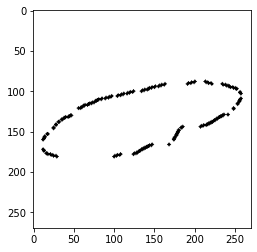

2


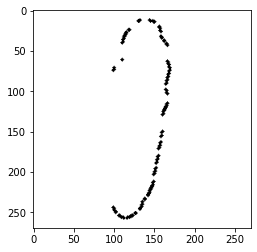

3


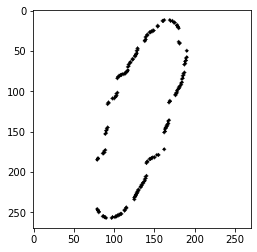

4


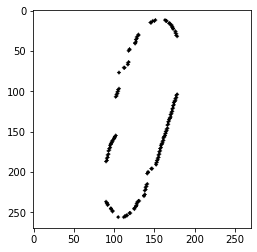

5


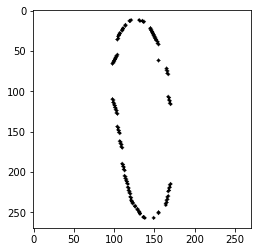

6


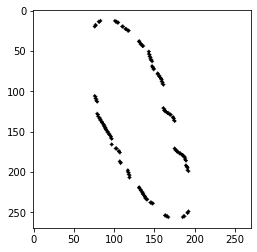

7


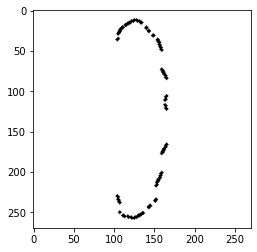

8


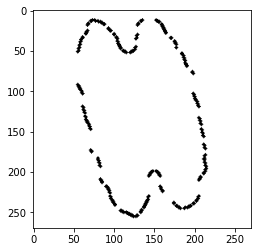

9


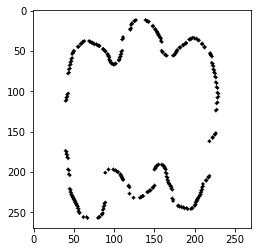

10


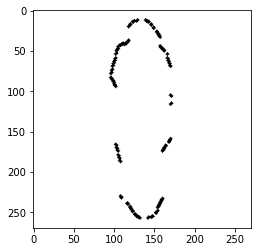

11


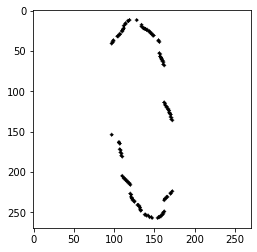

12


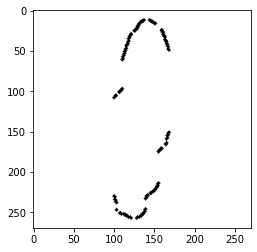

13


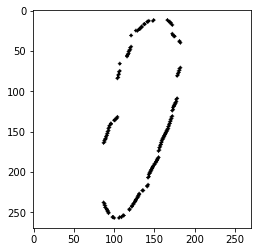

14


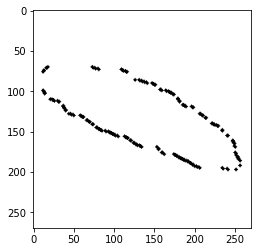

In [66]:
props_test = list()
for i in range(len(props)):
    img_test = props[i]
    scaled_test = scale_img(img_test, 400)
    props_img = cv2.cvtColor(props[i], cv2.COLOR_GRAY2BGR)
    props_img = scale_img(props_img, 400)
    
    enhanced = enhanceAndFill(scaled_test)
    markers, _ = watershedSegmentation(enhanced, props_img)
    rotated = rotate2(markers, 0)
    resized = resizeAndPad(rotated, (img_size,img_size))

    blurred = cv2.medianBlur(resized, 11)
    _, final = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    cnts, h = cv2.findContours(final, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    c = sorted(cnts, key=cv2.contourArea)

    efd = extract_efd(c[-2])
    props_test.append(efd)
    
    print(i+1)
#     plt.imshow(final)
    plt.imshow(cv2.drawContours(np.ones(resized.shape), c[-2], -1, (0, 255, 0), 3), cmap='gray')
    plt.show()

In [ ]:
egg_obj = props_test.copy()
egg_obj = scaler.transform(np.array(egg_obj)) # abis nge-fit ini, fit lagi pake X,y
egg_obj = pca.transform(egg_obj)

pred_label = search.predict_proba(egg_obj)
[np.argmax(i) for i in pred_label]

In [ ]:
img2 = img1.copy()
alpha = 10
egg = 0
notegg = 0
egglist = list()

for i, ((x,y,w,h), probs) in enumerate(zip(boxes, pred_label)):
    p = np.argmax(probs)
    if p == 0:
        cv2.rectangle(img2, (x-alpha,y-alpha), (x+w+alpha, y+h+alpha), (255,0,0), rect_width)
        cv2.putText(img2, f"not: {round(np.max(probs),2)}", (int(x)-alpha, int(y)-alpha*2), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0),font_width)
        notegg += 1
    elif p == 1:
        cv2.rectangle(img2, (x-alpha,y-alpha), (x+w+alpha, y+h+alpha), (0,255,0), rect_width)
        cv2.putText(img2, f"egg: {round(np.max(probs),2)}", (int(x)-alpha, int(y)-(alpha*2)), cv2.FONT_HERSHEY_SIMPLEX, font_size, (0, 0, 255), font_width)
        egg += 1
        egglist.append((props_test[i], i))

objects_detected = egg + notegg
cv2.putText(img2, f'Detected {objects_detected} objects: {egg} eggs, {notegg} non-egg objects',
           (10,30), cv2.FONT_HERSHEY_SIMPLEX, font_size, (0, 0, 255), font_width)
plt.figure(figsize=(20,15))
plt.imshow(img2, cmap='gray')
plt.show()

In [ ]:
pred_label = list()
egg_num = list()

for f, i in egglist:
    pred_label.append(search_efd.predict_proba(f.reshape(1,-1)))
    egg_num.append(i)

In [ ]:
img3 = img1.copy()
alpha = 10
aeg, alb = 0, 0

for i, probs in zip(egg_num, pred_label):
    x,y,w,h = boxes[i]
    p = np.argmax(probs)
    if p == 0:
        cv2.rectangle(img3, (x-alpha,y-alpha), (x+w+alpha, y+h+alpha), (0,255,0), rect_width)
        cv2.putText(img3, f"{round(np.max(probs),2)}", (int(x)-alpha, int(y)-alpha*2), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0), font_width)
        aeg += 1
    elif p == 1:
        cv2.rectangle(img3, (x-alpha,y-alpha), (x+w+alpha, y+h+alpha), (0,255,0), rect_width)
        cv2.putText(img3, f"{round(np.max(probs),2)}", (int(x)-alpha, int(y)-(alpha*2)), cv2.FONT_HERSHEY_SIMPLEX, font_size, (0, 0, 255), font_width)
        alb += 1
        
cv2.putText(img3, f'Detected {egg} eggs:', (10,30), cv2.FONT_HERSHEY_SIMPLEX, font_size, (0, 255, 0), font_width)
cv2.putText(img3, f'- Ae. aegypti (Red): {aeg} eggs', (10,50), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0), font_width)
cv2.putText(img3, f'- Ae. albopictus (Blue): {alb} eggs', (10,70), cv2.FONT_HERSHEY_SIMPLEX, font_size, (0, 0, 255), font_width)

plt.figure(figsize=(25,20))
plt.imshow(img3, cmap='gray')
plt.show()

In [ ]:
# if pred == 0 (non-eggs), masuk sini dulu
def process_overlap(img):
    test = img.copy()
    test_rgb = cv2.cvtColor(test, cv2.COLOR_GRAY2BGR)

    otsu1 = cv2.adaptiveThreshold(test, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, otsu1thresh, 30)

    mask = np.invert(otsu1)
    imageROI = cv2.bitwise_and(test, test, mask=mask)
    imageROI[imageROI == 0] = 255

    _, otsu2 = cv2.threshold(imageROI, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    otsu2[otsu2 == 0] = 1
    otsu2[otsu2 == 255] = 0
    otsu2 = otsu2.astype(np.int8)
    filled1 = binary_fill_holes(otsu2)
    filled1 = filled1.astype(np.uint8)
    filled1[filled1 == 0] = 255
    filled1[filled1 == 1] = 0

    filled2 = filled1.copy()
    filled2 = np.invert(filled2)

    cnt, h = cv2.findContours(filled2, 2, 1)
    cnt = cnt[0]
    
    try:
        hull = cv2.convexHull(cnt, returnPoints=False)
        defects = cv2.convexityDefects(cnt, hull)
    except:
        defects = None
        pass
    
    new_box = list()
    new_pred = list()
    new_cnt = list()
    if defects is not None:
        asd = test.copy()
        dist = list()
        for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            dist.append(d)
        distmean = np.mean(dist)

        fp = list()
        for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            far = tuple(cnt[f][0])
            if d > distmean:
                fp.append(far)

        # works only for 2 eggs, creates 2 point, if fp > 2 then skip!!!!!!!!!!!
        # if len(fp) == 2: else: skip
        if len(fp) == 2:
            separated = cv2.line(np.invert(filled2), fp[0], fp[1], [255, 255, 255], 2) 
            cnt2, h = cv2.findContours(np.invert(separated), 2, 1)

            sep = test.copy()
            for i in range(len(cnt2)):
                x, y, w, h = cv2.boundingRect(cnt2[i])
                cv2.rectangle(sep, (x,y), (x+w, y+h), (0,255,0), 2)
                # masukin classifier
                efd = extract_efd(cnt2[i])
                egg_obj = scaler.transform(efd.reshape(1,-1))
                egg_obj = pca.transform(egg_obj)
                pred = search.predict_proba(egg_obj)
                if np.argmax(pred) == 1:
                    new_box.append((x,y,w,h))
                    new_pred.append(pred)
                    new_cnt.append(cnt2[i])
    return new_box, new_pred, new_cnt

### Segmentation

In [ ]:
img1 = cv2.imread("IMG_3803.jpeg")
# gs1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# otsu1 = cv2.adaptiveThreshold(gs1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 99, 30)

# mask = np.invert(otsu1)
# imageROI = cv2.bitwise_and(gs1, gs1, mask=mask)
# imageROI[imageROI == 0] = 255

# otsu2 = cv2.adaptiveThreshold(imageROI, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 99, 10)

# otsu2[otsu2 == 0] = 1
# otsu2[otsu2 == 255] = 0
# otsu2 = otsu2.astype(np.int8)
# filled1 = binary_fill_holes(otsu2)
# filled1 = filled1.astype(np.uint8)
# filled1[filled1 == 0] = 255
# filled1[filled1 == 1] = 0

# filled2 = filled1.copy()
# filled2 = np.invert(filled2)

# kernel = np.ones((3,3), np.uint8)
# WSopening = cv2.morphologyEx(filled2, cv2.MORPH_OPEN, kernel, iterations=2)

# sure_bg = cv2.dilate(WSopening, kernel, iterations=2)

# dist_transform = cv2.distanceTransform(WSopening, cv2.DIST_L2, 5)
# ret, sure_fg = cv2.threshold(dist_transform, 0.475*dist_transform.max(), 255, 0)

# sure_fg = np.uint8(sure_fg)
# unknown = cv2.subtract(sure_bg, sure_fg)

# # mark labelling
# ret, markers = cv2.connectedComponents(sure_fg)

# # add one to all labels
# markers = markers+1

# # mark the unknown with 0
# markers[unknown == 255] = 0

# markers = cv2.watershed(img1, markers)
# # img1[markers == -1] = [255, 0, 0]

# # finding contours from markers
# markers1 = markers.astype(np.uint8)
# ret, markers2 = cv2.threshold(markers1, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize=(15,7))
plt.imshow(img1)
plt.show()

In [ ]:
enhanced = enhanceAndFill(gs1)
_, segmented = watershedSegmentation(enhanced, img1)

plt.figure(figsize=(15,8))
plt.imshow(_, cmap='gray')
plt.show()

In [ ]:
boxes = list()
props = list()
img_copy = img1.copy()

for label in np.unique(segmented):
    if label == 0:
        continue
        
    mask = np.zeros(_.shape, dtype="uint8")
    mask[segmented == label] = 255
    
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    H, W = img1.shape[:2]
    x, y, w, h = cv2.boundingRect(c)
#     if (w / float(W) < 0.0075 or h / float(H) < 0.0075) or (w / float(W) > 0.5 or h / float(H) > 0.5):
    if (w / float(W) < 0.075 or h / float(H) < 0.075) or (w / float(W) > 0.5 or h / float(H) > 0.5):
        continue

    boxes.append((x,y,w,h))
    
    gamma = 8
    if x-gamma < 0 or y-gamma < 0:
        roi = gs1[0:y+h+gamma, 0:x+w+gamma]
    else:
        roi = gs1[y-gamma:y+h+gamma, x-gamma:x+w+gamma]
    props.append(roi)
    
for i, (x,y,w,h) in enumerate(boxes):
    cv2.rectangle(img_copy, (x,y), (x+w, y+h), (0,255,0), 2)
    cv2.putText(img_copy, "{}".format(i+1), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(15,7))
plt.imshow(img_copy)
plt.show()

print(f'{len(boxes)} eggs, i guess')

### Egg Model

#### Generating random shape

In [ ]:
from matplotlib.path import Path
import matplotlib.patches as patches

n = 2
r = .8
N = n*3+1

angles = np.linspace(0,2*np.pi,N)
codes = np.full(N, Path.CURVE4)
codes[0] = Path.MOVETO

for i in range(20):
    verts = np.stack((np.cos(angles), np.sin(angles))).T*(2*r*np.random.random(N)+1-r)[:,None]
    verts[-1,:] = verts[0,:]
    path = Path(verts, codes)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    patch = patches.PathPatch(path, facecolor='black', lw=2)
    ax.add_patch(patch)
    ax.set_xlim(np.min(verts)*1.1, np.max(verts)*1.1)
    ax.set_ylim(np.min(verts)*1.1, np.max(verts)*1.1)
    ax.axis('off')
#     plt.savefig(f'no{i}.jpg')

    plt.show()

In [ ]:
img_size = 250

img_new = cv2.imread('aegy_ref13.jpg')
enhanced = enhanceAndFill(img_new)
markers, _ = watershedSegmentation(enhanced, img_new)
rotated = rotate2(markers, 0)
resized = resizeAndPad(rotated, (img_size,img_size))

plt.figure(figsize=(15,8))
plt.imshow(_, cmap='gray')
plt.show()

#### Loading dataset

In [ ]:
data_dir = r'C:\Users\Nikko Prayudi\Documents\RISPRO\selectivetestimage\class/'
img_size = 250

def label_img(img_name):
    title = img_name.split('-')[0]
    if title == 'yes' : return 1
    elif title == 'no' or title == 'cr': return 0 

dataset = []
labels = []
i = 0    
for img in tqdm_notebook(listdir(data_dir)):
#     print(img, i)
    i += 1
    image_data = cv2.imread(data_dir+img)
#     image_data = cv2.resize(image_data, (img_size,img_size), interpolation = cv2.INTER_AREA)
#     image_data = image_data.flatten()
    label = label_img(img)
    dataset.append(image_data)
#     plt.figure()
#     plt.imshow(image_data)
#     plt.show()
    labels.append(label)


#### preprocessing data for the model

In [ ]:
f1 = list()
labels_ = list()

for i in tqdm_notebook(range(len(dataset))):
    for deg in tqdm_notebook(range(0,360,2)):
        img_test = dataset[i]
        lbl = labels[i]
    #         grayscaled = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
    #         _, thresholded = cv2.threshold(grayscaled, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #         resized = resizeAndPad(thresholded, (img_size,img_size))

        enhanced = enhanceAndFill(img_test)
        markers, _ = watershedSegmentation(enhanced, img_test)
        rotated = rotate2(markers, deg)
        resized = resizeAndPad(rotated, (img_size,img_size))

        blurred = cv2.medianBlur(resized, 11)
        _, final = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        cnts, h = cv2.findContours(final, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        c = sorted(cnts, key=cv2.contourArea)
        feature = extract_efd(c[-2])

        f1.append(feature)

        if lbl == 0:
            labels_.append(0)
        elif lbl == 1:
            labels_.append(1)
#         elif lbl == 2:
#             labels_.append(2)
#         pyefd.plot_efd(coeffs, n=16)    
#         plt.figure(figsize=(15,8))
#         plt.imshow(cv2.drawContours(np.ones(resized.shape), c[-2], -1, (0, 255, 0), 3), cmap='gray')
#         plt.show()

In [ ]:
pd.DataFrame(labels_)[0].value_counts()

#### Training

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel, ConstantKernel
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing
import datetime as dt

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
X = np.array(f1)
y = np.array(labels_)

scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=16)
X = pca.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32, stratify=y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# save PCA model
import joblib
# joblib.dump(pca, 'pca16-efd-090421.pkl')
# joblib.dump(scaler, 'scaler16-efd-090421.pkl')
pca = joblib.load("pca16-efd-090421.pkl")
scaler = joblib.load("scaler16-efd-090421.pkl")

In [ ]:
np.mean(X), np.std(X), np.min(X), np.max(X)

##### Visualize

In [ ]:
plt.figure(figsize=(15,8))
for l,c,m in zip(np.unique(y), ['r','g','b'], ['s','x','o']):
    plt.scatter(X[y==l,0],
                X[y==l,1],
               c=c, marker=m, label=l, edgecolors='black')

In [ ]:
X.shape

In [ ]:
df = pd.DataFrame(X)
df['label'] = y
df[df['label']==0]
df[df['label']==1]

In [ ]:
plt.figure(figsize=(15,8))
for lbl in np.unique(y):
    subset = df[df['label']==lbl]
    sns.distplot(subset[9], hist=False, kde=True,
           kde_kws={'shade':True, 'linewidth':3},
           label=lbl)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
pca.explained_variance_ratio_.sum()*100

In [ ]:
pca.components_.shape

In [ ]:
recons[0].reshape(1,-1).shape

In [ ]:
recons.mean(), recons.std()

In [ ]:
pd.DataFrame(recons).describe()

In [ ]:
for i in range(12):    
    first_comp = pca.components_[i].reshape(1,-1)
    first_proj = X[:,i].reshape(-1,1)

    recons = np.dot(first_proj, first_comp) + pca.mean_

    reconsmean = np.array(pd.DataFrame(recons).mean())
    recons_cont = pyefd.reconstruct_contour(reconsmean.reshape(1,-1))
    plt.scatter(pd.DataFrame(recons_cont)[0], pd.DataFrame(recons_cont)[1], color='b')

#     reconsstd = np.array(pd.DataFrame(recons).mean()) + 2*0.00000000000001*np.array(pd.DataFrame(recons).std())
#     recons_cont = pyefd.reconstruct_contour(reconsstd.reshape(1,-1))
#     plt.scatter(pd.DataFrame(recons_cont)[0], pd.DataFrame(recons_cont)[1], color='r')

#     reconsstd = np.array(pd.DataFrame(recons).mean()) - 2*0.00000000000001*np.array(pd.DataFrame(recons).std())
#     recons_cont = pyefd.reconstruct_contour(reconsstd.reshape(1,-1))
#     plt.scatter(pd.DataFrame(recons_cont)[0], pd.DataFrame(recons_cont)[1], color='g')
    plt.show()

##### MLP

In [ ]:
start = dt.datetime.now()
print(f'Start time: {start}')
print('-------------------------------------------')

model = MLPClassifier(max_iter=1000,
                      early_stopping=True,
                      random_state=32)

# define model evaluation method
cv = StratifiedKFold(n_splits=10)
scores = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score, pos_label=0)
#     'sensitivity2': make_scorer(recall_score, labels=[2], average=None),
#     'sensitivity': make_scorer(recall_score, labels=[1], average=None),
#     'specificity': make_scorer(recall_score, labels=[0], average=None)
}

parameter_grid = {
    'activation': ['logistic', 'relu', 'tanh'],
    'batch_size': [1, 2, 4],
    'hidden_layer_sizes': [i+1 for i in range(10)]
}

# define searchg
search = GridSearchCV(model,
                      parameter_grid,
                      cv=cv,
                      refit='accuracy',
                      scoring=scores,
                      n_jobs=-1,
                      pre_dispatch='1*n_jobs',
                      verbose=10)

# perform the search
results = search.fit(x_train, y_train)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

# summarize all
mean_acc = results.cv_results_['mean_test_accuracy']
mean_sens = results.cv_results_['mean_test_sensitivity']
mean_spec = results.cv_results_['mean_test_specificity']
params = results.cv_results_['params']
for acc, sen, spe, param in zip(mean_acc, mean_sens, mean_spec, params):
    print(f"> Accuracy: {round(acc*100,2)}%, Sens: {round(sen*100,2)}%, Specificity: {round(spe*100,2)}% with: {param}")
print('-------------------------------------------')
pred = search.predict(x_test)
print(classification_report(y_test, pred))
accuracy = accuracy_score(y_test, pred)
print('Model accuracy is: ', accuracy)
print('-------------------------------------------')
conf = confusion_matrix(y_test, pred)
print(conf)

print('-------------------------------------------')
print(f'Start time: {start}')
print(f'Done time: {dt.datetime.now()}')
print(f'Time consumed: {dt.datetime.now() - start}')
print('-------------------------------------------')

##### GPC

In [ ]:
'kernel': [var**2*RBF(length_scale=0.652) for var in np.linspace(200, 210, 5)]

In [ ]:
start = dt.datetime.now()
print(f'Start time: {start}')
print('-------------------------------------------')
kernel = 1*RBF(length_scale=1)
search = GaussianProcessClassifier(kernel=kernel, random_state=32)
search.fit(x_train, y_train)

print('-------------------------------------------')
pred = search.predict(x_test)
print(classification_report(y_test, pred))
accuracy = accuracy_score(y_test, pred)
print('Model accuracy is: ', accuracy)
print('-------------------------------------------')
conf = confusion_matrix(y_test, pred)
print(conf)

print('-------------------------------------------')
print(f'Start time: {start}')
print(f'Done time: {dt.datetime.now()}')
print(f'Time consumed: {dt.datetime.now() - start}')
print('-------------------------------------------')

In [ ]:
start = dt.datetime.now()
print(f'Start time: {start}')
print('-------------------------------------------')
gpc = GaussianProcessClassifier(random_state=32)

# define model evaluation method
cv = StratifiedKFold(n_splits=10)
scores = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score, pos_label=0)
}

parameter_grid = {
    'kernel': [1*RBF(),
               1*Matern(nu=0.5)]
}

# define search
search = GridSearchCV(gpc,
                      parameter_grid,
                      cv=cv,
                      refit='accuracy',
                      scoring=scores,
                      n_jobs=-1,
                      pre_dispatch='1*n_jobs',
                      verbose=10)

# perform the search
results = search.fit(x_train, y_train)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

# summarize all
mean_acc = results.cv_results_['mean_test_accuracy']
mean_sens = results.cv_results_['mean_test_sensitivity']
mean_spec = results.cv_results_['mean_test_specificity']
params = results.cv_results_['params']
for acc, sen, spe, param in zip(mean_acc, mean_sens, mean_spec, params):
    print(f"> Accuracy: {round(acc*100,2)}%, Sensitivity: {round(sen*100,2)}%, Specificity: {round(spe*100,2)}% with: {param}")
print('-------------------------------------------')
pred = search.predict(x_test)
print(classification_report(y_test, pred))
accuracy = accuracy_score(y_test, pred)
print('Model accuracy is: ', accuracy)
print('-------------------------------------------')
conf = confusion_matrix(y_test, pred)
print(conf)

print('-------------------------------------------')
print(f'Start time: {start}')
print(f'Done time: {dt.datetime.now()}')
print(f'Time consumed: {dt.datetime.now() - start}')
print('-------------------------------------------')

##### Feature Selection using RFE

In [ ]:
def get_models():
    models = dict()
    for i in range(2, len(pd.DataFrame(X).columns)):
        rfe = RFE(estimator=SVC(kernel='linear'), n_features_to_select=i)
        model = SVC(kernel='linear')
        models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=32)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, verbose=10, error_score='raise')
    return scores

In [ ]:
X.shape, y.shape

In [ ]:
models = get_models()
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print(f'{name}: {np.mean(scores)}')

In [ ]:
gpc = GaussianProcessClassifier(kernel=RBF(length_scale=1), random_state=32)

gpc.fit(x_train, y_train)

pred_efd = gpc.predict(x_test)
print(classification_report(y_test, pred_efd))
accuracy_efd = accuracy_score(y_test, pred_efd)
print('Model accuracy is: ', accuracy_efd)
conf_efd = confusion_matrix(y_test, pred_efd)
print(conf_efd)

In [ ]:
gpc.score(x_train, y_train)

In [ ]:
gpc.score(x_test, y_test)

In [ ]:
gpc = GaussianProcessClassifier(random_state=32)

# define model evaluation method
cv = StratifiedKFold(n_splits=10)
scores = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score, pos_label=0)
}

parameter_grid = {
    'kernel': [1*RBF(length_scale=i) for i in np.linspace(0,1,101)]
}

# define search
search_efd = GridSearchCV(gpc,
                      parameter_grid,
                      cv=cv,
                      refit='accuracy',
                      scoring=scores,
                      n_jobs=-1,
                      verbose=10)

# perform the search
results_efd = search_efd.fit(x_train, y_train)
# summarize best
print('Best Mean Accuracy: %.3f' % results_efd.best_score_)
print('Best Config: %s' % results_efd.best_params_)

# summarize all
mean_acc = results_efd.cv_results_['mean_test_accuracy']
mean_sens = results_efd.cv_results_['mean_test_sensitivity']
mean_spec = results_efd.cv_results_['mean_test_specificity']
params = results_efd.cv_results_['params']
for acc, sen, spe, param in zip(mean_acc, mean_sens, mean_spec, params):
    print(f"> Accuracy: {round(acc*100,2)}%, Sensitivity: {round(sen*100,2)}%, Specificity: {round(spe*100,2)}% with: {param}")

pred_efd = search_efd.predict(x_test)
print(classification_report(y_test, pred_efd))
accuracy_efd = accuracy_score(y_test, pred_efd)
print('Model accuracy is: ', accuracy_efd)
conf_efd = confusion_matrix(y_test, pred_efd)
print(conf_efd)

In [ ]:
search_efd.best_params_

### Classifying proposed boxes

In [ ]:
# joblib.dump(search, 'gpc-efd-pca12-080421.pkl')
search = joblib.load("mlp-efd-pca16-070421.pkl")
search.best_params_

In [ ]:
search.kernel_

In [ ]:
from mlxtend.plotting import plot_learning_curves

plot_learning_curves(x_train, y_train, x_test, y_test, search)
plt.show()

In [ ]:
img_size = 250
props_test = list()

for i in tqdm_notebook(range(len(props))):
    props_img = cv2.cvtColor(props[i], cv2.COLOR_GRAY2BGR)
    enhanced = enhanceAndFill(props_img)
    markers, _ = watershedSegmentation(enhanced, props_img)
    rotated = rotate(markers, 0)
    resized = resizeAndPad(rotated, (img_size,img_size))

    blurred = cv2.medianBlur(resized, 11)
    _, final = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    cnts, h = cv2.findContours(final, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    c = sorted(cnts, key=cv2.contourArea)

    efd = extract_efd(c[-2])
    props_test.append(efd)
    
    plt.imshow(cv2.drawContours(np.ones(resized.shape), c[-2], -1, (0, 255, 0), 3), cmap='gray')
    plt.show()
#     plt.imshow(resized, cmap='gray')
#     plt.show()

In [ ]:
search.best_params_

In [ ]:
props_test = scaler.transform(np.array(props_test)) # abis nge-fit ini, fit lagi pake X,y
props_test = pca.transform(props_test)

pred_label = search.predict_proba(props_test)
[np.argmax(i) for i in pred_label]

In [ ]:
img2 = img1.copy()
for i, ((x,y,w,h), probs) in enumerate(zip(boxes, pred_label)):
    p = np.argmax(probs)
    if p == 0:
        cv2.rectangle(img2, (x,y), (x+w, y+h), (255,0,0), 2)
        cv2.putText(img2, f"not: {round(np.max(probs),2)}", (int(x), int(y)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 2)
    elif p == 1:
        cv2.rectangle(img2, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(img2, f"egg: {round(np.max(probs),2)}", (int(x), int(y)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 2)

plt.figure(figsize=(18,10))
plt.imshow(img2, cmap='gray')
plt.show()

In [ ]:
props[0].shape

In [ ]:
def preprocess_img(img, img_size=250, degree=0):
    global resized
    enhanced = enhanceAndFill(img)
    markers = watershedSegmentation(enhanced)
    rotated = rotate(markers, degree)
    resized = resizeAndPad(rotated, (img_size,img_size))
    c = get_contour(resized)
    return c

In [ ]:
blurred = cv2.GaussianBlur(img1, (5,5),0)
plt.figure(figsize=(15,7))
plt.imshow(blurred, cmap='gray')
plt.show()

In [ ]:
kernel = np.zeros((15,15), np.uint8)

can = cv2.Canny(blurred, 0, 233)

plt.figure(figsize=(15,7))
plt.imshow(filled, cmap='gray')
plt.show()

In [ ]:
aeg1 = cv2.adaptiveThreshold(lap, 0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 0, 1)
plt.figure(figsize=(15,7))
plt.imshow(aeg1, cmap='gray')
plt.show()

In [ ]:
sobel = cv2.Sobel(blurred, cv2.CV_64F, 1, 1, ksize=5)

plt.figure(figsize=(15,7))
plt.imshow(sobel, cmap='gray')
plt.show()